In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm.auto import tqdm
import glob
import os
import sys

# pip3 install --user PyMuPDF
import fitz

In [27]:
%%bash
# https://www.google.com/covid19/mobility/
mkdir -p pdfs/
cd pdfs/

states="Alabama Alaska Arizona Arkansas California Colorado Connecticut Delaware Florida Georgia Hawaii Idaho Illinois Indiana Iowa Kansas Kentucky Louisiana Maine Maryland Massachusetts Michigan Minnesota Mississippi Missouri Montana Nebraska Nevada New_Hampshire New_Jersey New_Mexico New_York North_Carolina North_Dakota Ohio Oklahoma Oregon Pennsylvania Rhode_Island South_Carolina South_Dakota Tennessee Texas Utah Vermont Virginia Washington West_Virginia Wisconsin Wyoming"
date="2020-03-29"
for state in $states ; do
    curl -s -O https://www.gstatic.com/covid19/mobility/${date}_US_${state}_Mobility_Report_en.pdf
done
# rename the full US pdf slightly to conform to similar naming convention as the individual states
curl -s -o ${date}_US_US_Mobility_Report_en.pdf https://www.gstatic.com/covid19/mobility/${date}_US_Mobility_Report_en.pdf

In [13]:
def parse_stream(stream):
    data_raw = []
    data_transformed = []
    rotparams = None
    npatches = 0
    for line in stream.splitlines():
        if line.endswith(" cm"):
            # page 146 of https://www.adobe.com/content/dam/acom/en/devnet/pdf/pdfs/pdf_reference_archives/PDFReference.pdf
            rotparams = list(map(float,line.split()[:-1]))
        elif line.endswith(" l"):
            x,y = list(map(float,line.split()[:2]))
            a,b,c,d,e,f = rotparams
            xp = a*x+c*y+e
            yp = b*x+d*y+f
            data_transformed.append([xp,yp])
            data_raw.append([x,y])
        elif line.endswith(" m"):
            npatches += 1
        else:
            pass
    data_raw = np.array(data_raw)
    basex, basey = data_raw[-1]
    good = False
    if basex == 0.:
        data_raw[:,1] = basey - data_raw[:,1]
        data_raw[:,1] *= 100/60.
        data_raw = data_raw[data_raw[:,1]!=0.]
        if npatches == 1: good = True
    return dict(data=np.array(data_raw), npatches=npatches, good=good)

In [28]:
def parse_page(doc, ipage, verbose=False):
    categories = [
        "Retail & recreation",
        "Grocery & pharmacy",
        "Parks",
        "Transit stations",
        "Workplace",
        "Residential",
    ]

    counties = []
    curr_county = None
    curr_category = None
    data = defaultdict(lambda: defaultdict(list))
    pagetext = doc.getPageText(ipage)
    lines = pagetext.splitlines()
    tickdates = list(filter(lambda x:len(x.split())==3, set(lines[-10:])))
    for line in lines:
        # don't need these lines at all
        if ("* Not enough data") in line: continue
        if ("needs a significant volume of data") in line: continue

        # if we encountered a category, add to dict, otherwise
        # push all seen lines into the existing dict entry
        if any(line.startswith(c) for c in categories):
            curr_category = line
        elif curr_category:
            data[curr_county][curr_category].append(line)

        # If it doesn't match anything, then it's a county name
        if (all(c not in line for c in categories)
            and ("compared to baseline" not in line)
            and ("Not enough data" not in line)
           ):
            # saw both counties already
            if len(data.keys()) == 2: break
            counties.append(line)
            curr_county = line

    newdata = {}
    for county in data:
        newdata[county] = {}
        for category in data[county]:
            # if the category text ends with a space, then there was a star/asterisk there
            # indicating lack of data. we skip these.
            if category.endswith(" "): continue
            temp = [x for x in data[county][category] if "compared to baseline" in x]
            if not temp: continue
            percent = int(temp[0].split()[0].replace("%",""))
            newdata[county][category.strip()] = percent
    data = newdata

    tomatch = []
    for county in counties:
        for category in categories:
            if category in data[county]:
                tomatch.append([county,category,data[county][category]])
    if verbose:
        print(len(tomatch))
        print(data)
    
    goodplots = []
    xrefs = sorted(doc.getPageXObjectList(ipage), key=lambda x:int(x[1].replace("X","")))
    for i,xref in enumerate(xrefs):
        stream = doc.xrefStream(xref[0]).decode()
        info = parse_stream(stream)
        if not info["good"]: continue
        goodplots.append(info)
    if verbose:
        print(len(goodplots))
    
    ret = []
    
    if len(tomatch) != len(goodplots):
        return ret
    
    
    for m,g in zip(tomatch,goodplots):
        xs = g["data"][:,0]
        ys = g["data"][:,1]
        maxys = ys[np.where(xs==xs.max())[0]]
        maxy = maxys[np.argmax(np.abs(maxys))]
        
        
        # parsed the tick date labels as text. find the min/max (first/last)
        # and make evenly spaced dates, one per day, to assign to x values between
        # 0 and 200 (the width of the plots).
        ts = list(map(lambda x: pd.Timestamp(x.split(None,1)[-1] + ", 2020"), tickdates))
        low, high = min(ts), max(ts)
        dr = list(map(lambda x:str(x).split()[0], pd.date_range(low, high, freq="D")))
        lutpairs = list(zip(np.linspace(0,200,len(dr)),dr))

        dates = []
        values = []
        asort = xs.argsort()
        xs = xs[asort]
        ys = ys[asort]
        for x,y in zip(xs,ys):
            date = min(lutpairs, key=lambda v:abs(v[0]-x))[1]
            dates.append(date)
            values.append(round(y,3))

        ret.append(dict(
            county=m[0],category=m[1],change=m[2],
            values=values,
            dates=dates,
            changecalc=maxy,
        ))
    return ret


In [29]:
!mkdir -p data/

def parse_state(state):
    doc = fitz.Document(f"pdfs/2020-03-29_US_{state}_Mobility_Report_en.pdf")
    data = []
    for i in range(2,doc.pageCount-1):
        for entry in parse_page(doc, i):
            entry["state"] = state
            entry["page"] = i
            data.append(entry)
    outname = f"data/{state}.json.gz"
    df = pd.DataFrame(data)
    ncounties = df['county'].nunique()
    print(f"Parsed {len(df)} plots for {ncounties} counties in {state}")
    df = df[["state","county","category","change","changecalc","dates", "values","page"]]
    return df


In [30]:
parse_state("New_York")

Parsed 207 plots for 47 counties in New_York


,state,county,category,change,changecalc,dates,values,page
0,New_York,Albany County,Retail & recreation,-59,-61.825713,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[6.817, 11.943, -7.269, 4.15, 2.239, 0.712, 9....",2
1,New_York,Albany County,Grocery & pharmacy,-30,-31.368892,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-5.853, 1.91, -7.346, -3.023, -3.381, -5.249,...",2
2,New_York,Albany County,Parks,-15,-15.432097,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[8.681, -23.521, -34.124, -22.363, -8.464, -9....",2
3,New_York,Albany County,Transit stations,-64,-66.587550,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-0.659, -7.722, 0.17, 1.691, -2.326, -4.777, ...",2
4,New_York,Albany County,Workplace,-36,-37.739322,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[1.994, -42.578, -9.492, -8.561, -7.879, -9.87...",2
...,...,...,...,...,...,...,...,...
202,New_York,Wyoming County,Grocery & pharmacy,-4,-4.585953,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[1.965, 4.735, -11.184, -2.706, 1.947, -2.713,...",31
203,New_York,Wyoming County,Workplace,-21,-21.802323,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[6.056, -24.547, -14.925, -11.539, -8.733, -9....",31
204,New_York,Yates County,Retail & recreation,-34,-35.919545,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[43.103, 3.561, -1.844, 8.648, 5.977, 4.365, 2...",32
205,New_York,Yates County,Grocery & pharmacy,-13,-13.973580,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[6.352, -8.198, -3.931, -0.965, -3.823, -5.928...",32


In [31]:
# US will be included in the dataframe as a "state", and the states are "counties"
parse_state("US").head()

Parsed 306 plots for 51 counties in US


,state,county,category,change,changecalc,dates,values,page
0,US,Alabama,Retail & recreation,-41,-42.436015,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-0.284, 3.589, -4.107, 3.814, -6.916, 3.289, ...",2
1,US,Alabama,Grocery & pharmacy,-13,-14.002120,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-2.265, -0.266, -3.379, 1.154, -5.9, -0.154, ...",2
2,US,Alabama,Parks,19,19.841270,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-7.096, 17.869, -11.458, 6.701, -26.479, 12.1...",2
3,US,Alabama,Transit stations,-30,-31.353645,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[2.915, 7.12, -1.241, 4.388, -0.888, 9.356, 13...",2
4,US,Alabama,Workplace,-32,-32.935372,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-1.485, -17.445, 0.882, 1.178, -0.464, 1.269,...",2


In [32]:
import glob
states = [x.split("_US_",1)[1].split("_Mobility",1)[0] for x in glob.glob("pdfs/*.pdf")]
dfs = []
for state in states:
    dfs.append(parse_state(state))
df = pd.concat(dfs).reset_index(drop=True)
data = []
for i,row in tqdm(df.iterrows()):
    # do a little clean up and unstack the dates/values as separate rows
    dorig = dict()
    dorig["state"] = row["state"].replace("_"," ")
    dorig["county"] = row["county"]
    dorig["category"] = row["category"].replace(" & ","/").replace(" ","").lower()
    dorig["page"] = row["page"]
    dorig["change"] = row["change"]
    dorig["changecalc"] = row["changecalc"]
    for x,y in zip(row["dates"],row["values"]):
        d = dorig.copy()
        d["date"] = x
        d["value"] = y
        data.append(d)
df = pd.DataFrame(data)
df.to_json("data/data.json.gz", orient="records", indent=2)

Parsed 228 plots for 70 counties in Illinois
Parsed 119 plots for 31 counties in South_Carolina
Parsed 60 plots for 11 counties in Massachusetts
Parsed 329 plots for 99 counties in Georgia
Parsed 154 plots for 51 counties in Mississippi
Parsed 187 plots for 69 counties in Kentucky
Parsed 283 plots for 93 counties in Virginia
Parsed 107 plots for 25 counties in Oregon
Parsed 152 plots for 46 counties in Louisiana
Parsed 171 plots for 51 counties in Alabama
Parsed 283 plots for 73 counties in Ohio
Parsed 131 plots for 37 counties in Colorado
Parsed 260 plots for 51 counties in Florida
Parsed 173 plots for 48 counties in Michigan
Parsed 207 plots for 47 counties in New_York
Parsed 99 plots for 35 counties in Kansas
Parsed 8 plots for 2 counties in Rhode_Island
Parsed 86 plots for 20 counties in Maryland
Parsed 152 plots for 50 counties in Minnesota
Parsed 16 plots for 3 counties in Delaware
Parsed 518 plots for 148 counties in Texas
Parsed 136 plots for 44 counties in Oklahoma
Parsed 28 p

In [33]:
dfc = pd.read_json("data/data.json.gz")
dfc["date"] = pd.to_datetime(dfc["date"])

In [34]:
len(dfc)

294044

In [35]:
dfc["category"].value_counts()

retail/recreation    77318
grocery/pharmacy     74859
workplace            67077
transitstations      30982
residential          25172
parks                18636
Name: category, dtype: int64

Text(0.5, 1.0, 'workplace for New York counties')

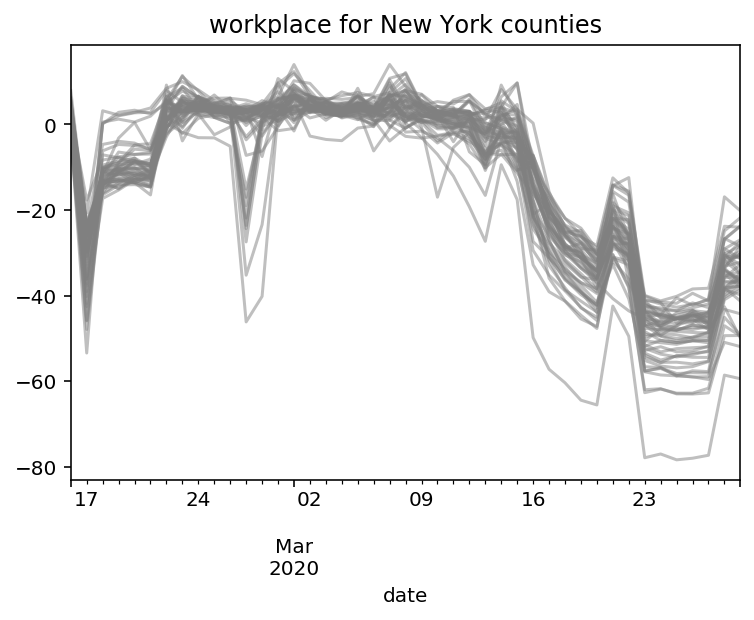

In [36]:
fig, ax = plt.subplots()
state = "New York"
category = "workplace"
dfc[(dfc["state"]==state) & (dfc["category"]==category)].set_index("date").groupby("county")["value"].plot(
    ax=ax,color="gray",
    alpha=0.5,
);
ax.set_title(f"{category} for {state} counties")